# Predict Future Values of Emissions

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
#from sklearn.utils import shuffle
import json
import random
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [2]:
# Read in emission data
emission_data = pd.read_csv('../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
print(f"Shape output data: {emission_data.shape}")

Shape output data: (372,)


In [3]:
data= pd.Series(emission_data)
split_train = np.arange(0, len(data)-12)
split_test = np.arange((len(data)-12), len(data))
train_data = pd.Series(data, index=split_train)
test_data = pd.Series(data, index=split_test)

# Auto Sarima Model

In [4]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=717.429, BIC=736.690, Time=1.687 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=1403.583, BIC=1411.288, Time=0.039 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=757.013, BIC=772.421, Time=0.815 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=1070.896, BIC=1086.305, Time=0.692 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=1475.419, BIC=1479.271, Time=0.028 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=945.975, BIC=961.384, Time=0.261 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=692.153, BIC=715.266, Time=2.120 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=758.887, BIC=778.148, Time=0.938 seconds
Fit ARIMA(1,0,1)x(2,1,1,12) [intercept=True]; AIC=693.927, BIC=720.892, Time=7.694 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=693.922, BIC=720.887, Time=7.632 seconds
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  360
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -340.805
Date:                              Thu, 06 Aug 2020   AIC                            691.611
Time:                                      17:27:34   BIC                            710.872
Sample:                                           0   HQIC                           699.279
                                              - 360                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0451      0.029     -1.536      0.125      -0.103       0.012
ar.L1          0.9614      0.018     53.502      0.000       0.926       0.997
ar.S.L12      -0.3167      0.027    -11.571      0.000      -0.370      -0.263
ma.S.L12      -0.7310      0.033    -22.000      0.000      -0.796      -0.666
sigma2         0.3959      0.010     39.167      0.000       0.376       0.416
===================================================================================
Ljung-Box (Q):                       48.22   Jarque-Bera (JB):              8511.67
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

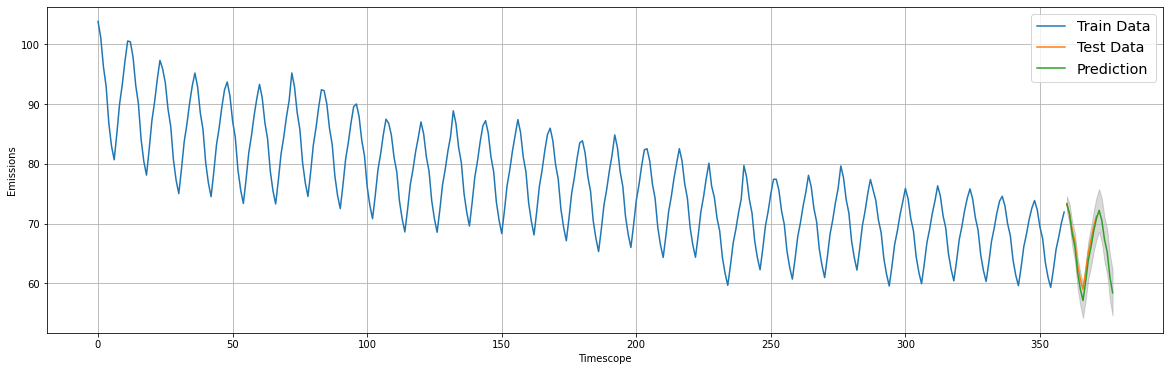

In [5]:
# Forecast
n_periods = 18
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
index_of_fc = np.arange(len(data)-12, len(data)-12+n_periods)
index_of_test = np.arange(len(data)-12, len(data))

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
test_series = pd.Series(test_data, index=index_of_test)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(train_data, label='Train Data')
line3 = plt.plot(test_series, label='Test Data')
line2 = plt.plot(fitted_series, label='Prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks()
plt.xlabel("Timescope")
plt.ylabel("Emissions")
plt.show()

In [6]:
# Accuracy metrics
fitted = fitted[0:12]
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    print("Accuracy of the model:")
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
forecast_accuracy(fitted, test_data)

Accuracy of the model:


{'mape': 0.01567561364934011,
 'me': -0.9709790343188972,
 'mae': 1.002923781432406,
 'mpe': -0.01523902193574665,
 'rmse': 1.14702026930718,
 'corr': 0.999451043458532,
 'minmax': 0.015675043306408898}